In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew 


%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

In [4]:
SCRIPT_DIR = os.getcwd()
DATA_DIR = os.path.join(SCRIPT_DIR, '..', 'data')
print DATA_DIR

/Users/aravind/movie-ranking-recommendation-system/notebooks/../data


In [5]:
meta_data = pd.read_csv(DATA_DIR + '/movies_metadata.csv')
nsfw_data = pd.read_csv(DATA_DIR + '/nsfw_score.csv')
print meta_data.shape
print nsfw_data.shape

(45466, 24)
(45047, 2)


/Users/aravind/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
#Changing the column name
nsfw_data.columns = ['id', 'nsfw_score']

#Only using relevant data from the main csv
meta_data_subset = meta_data[['title', 'budget', 'id', 'original_language', 'popularity', 'revenue', 'vote_average', 'vote_count']]

#Converting both fields to the same data type
meta_data_subset['id'] = meta_data_subset['id'].astype(str)
nsfw_data['id'] = nsfw_data['id'].astype(str)

/Users/aravind/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
#merging the two dataframes
df = meta_data_subset.merge(nsfw_data, on='id', how='left')

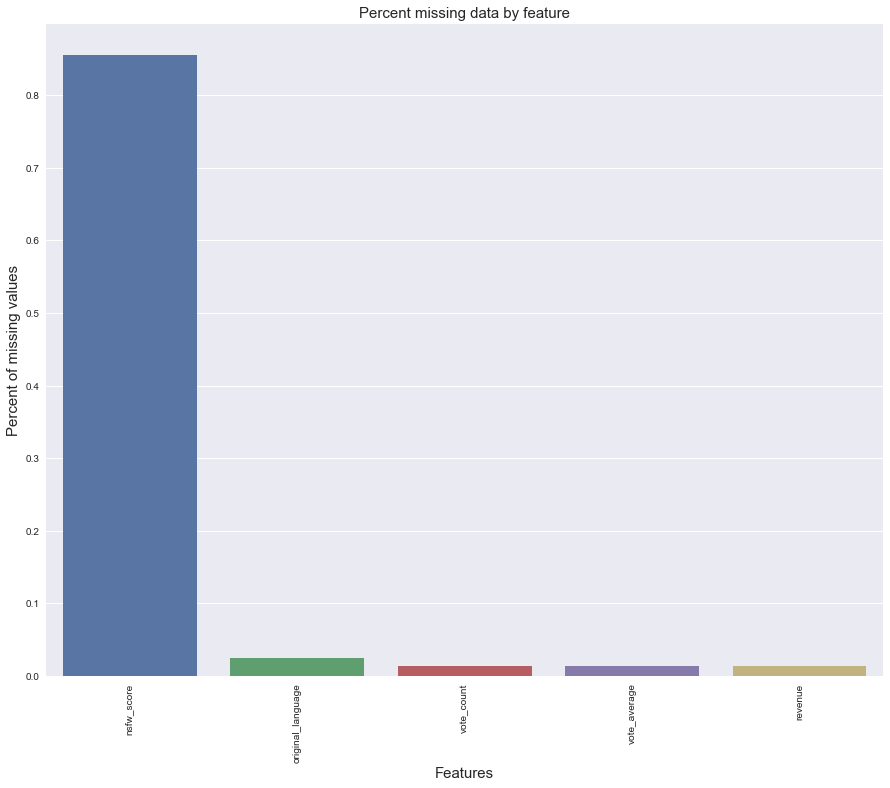

In [29]:
#Looking for missing values
df_na = (df.isnull().sum() / len(df)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:5]
missing_data = pd.DataFrame({'Missing Ratio' :df_na})

#plotting the missing data by percentages
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=df_na.index, y=df_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

We were unable to scrape the posters for 0.9% of the data, so we could not calculate the nsfw scores for those movies. This is insignifcant considering the size of our dataset. We can drop the missing values:

In [30]:
df.head()

,title,budget,id,original_language,popularity,revenue,vote_average,vote_count,nsfw_score
0,Toy Story,30000000,862,en,21.9469,373554033.0,7.7,5415.0,0.000582
1,Jumanji,65000000,8844,en,17.0155,262797249.0,6.9,2413.0,0.003873
2,Grumpier Old Men,0,15602,en,11.7129,0.0,6.5,92.0,0.010151
3,Waiting to Exhale,16000000,31357,en,3.85949,81452156.0,6.1,34.0,0.025879
4,Father of the Bride Part II,0,11862,en,8.38752,76578911.0,5.7,173.0,0.004546


In [31]:
#Dropping rows that have missing data
movie_data = df.dropna(axis=0)
print '{} rows dropped'.format(df.shape[0] - movie_data.shape[0])

400 rows dropped


In [32]:
#checking the data type of the columns
print movie_data.dtypes

title                 object
budget                object
id                    object
original_language     object
popularity            object
revenue              float64
vote_average         float64
vote_count           float64
nsfw_score           float64
dtype: object


In [121]:
#converting the data types as neccesary
movie_data.loc[:, 'budget'] = pd.to_numeric(movie_data['budget'])
movie_data.loc[:, 'original_language'] = movie_data.original_language.astype(str)
movie_data.loc[:,'popularity'] = pd.to_numeric(movie_data['popularity'])
print movie_data.dtypes

title                 object
budget                 int64
id                    object
original_language     object
popularity           float64
revenue              float64
vote_average         float64
vote_count           float64
nsfw_score           float64
dtype: object


In [122]:
#dropping rows with missing data
movie_df = movie_data.replace(0,'NaN')
movie_df = movie_df[(movie_df.revenue != 'NaN') & (movie_df.revenue != 'NaN') & (movie_df.budget != 'NaN')]
print '{} rows dropped'.format(movie_data.shape[0] - movie_df.shape[0])
#replacing NaNs with 0 everywhere else
movie_df = movie_df.replace('NaN', 0)

39685 rows dropped


In [123]:
movie_df.dtypes

title                 object
budget                 int64
id                    object
original_language     object
popularity           float64
revenue              float64
vote_average         float64
vote_count           float64
nsfw_score           float64
dtype: object

In [124]:
#converting the data types again for some fucking reason
movie_df.loc[:, 'budget'] = pd.to_numeric(movie_df['budget'])
movie_df.loc[:, 'popularity'] = pd.to_numeric(movie_df['popularity'])
movie_df.loc[:, 'revenue'] = pd.to_numeric(movie_df['revenue'])
movie_df.loc[:, 'vote_average'] = pd.to_numeric(movie_df['vote_average'])
movie_df.loc[:, 'vote_count'] = pd.to_numeric(movie_df['vote_count'])
movie_df.loc[:, 'nsfw_score'] = pd.to_numeric(movie_df['nsfw_score'])
movie_df.dtypes

title                 object
budget                 int64
id                    object
original_language     object
popularity           float64
revenue              float64
vote_average         float64
vote_count           float64
nsfw_score           float64
dtype: object

In [126]:
#checking for skew
numeric_feats = movie_df.dtypes[(movie_df.dtypes != "object")].index
print 'The number of numeric features are {}'.format(numeric_feats.shape[0])
# Check the skew of all numerical features
skewed_feats = movie_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(30)

The number of numeric features are 6


,Skew
popularity,18.467573
nsfw_score,4.938871
revenue,4.477213
vote_count,3.723897
budget,2.518972
vote_average,-0.860078


In [128]:
#Using log transform on nsfw_score since it normalizes better than boxcox
movie_df.loc[:, 'nsfw_score'] = np.log(movie_df['nsfw_score'])

# Check the skew of all numerical features
skewed_feats = movie_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(30)

,Skew
popularity,18.467573
revenue,4.477213
vote_count,3.723897
budget,2.518972
nsfw_score,-0.224311
vote_average,-0.860078


In [129]:
#Using Box Cox Transform to fix skewed features
skewness = skewness[skewness['Skew'] > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    movie_df[feat] = boxcox1p(movie_df[feat], lam)

There are 4 skewed numerical features to Box Cox transform


In [130]:
#Checking skew again
skewed_feats = movie_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(30)

,Skew
popularity,0.234453
vote_count,0.234119
nsfw_score,-0.224311
revenue,-0.232498
budget,-0.597465
vote_average,-0.860078


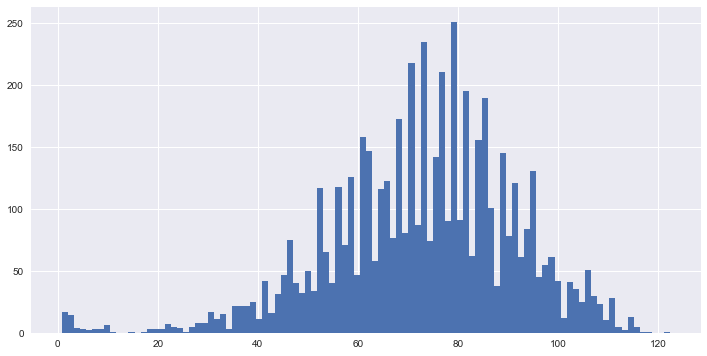

In [133]:
#Looking at distribtuion of NSFW Scores
plt.hist(movie_df['budget'], bins=100)
plt.show()

The data is very skewed, we need to log transform it.


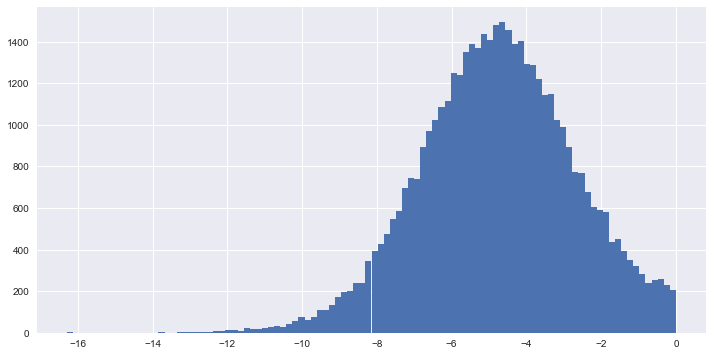

In [18]:
plt.hist(np.log(movie_data['nsfw_score']), bins=100)
plt.show()

### Popularity Analysis

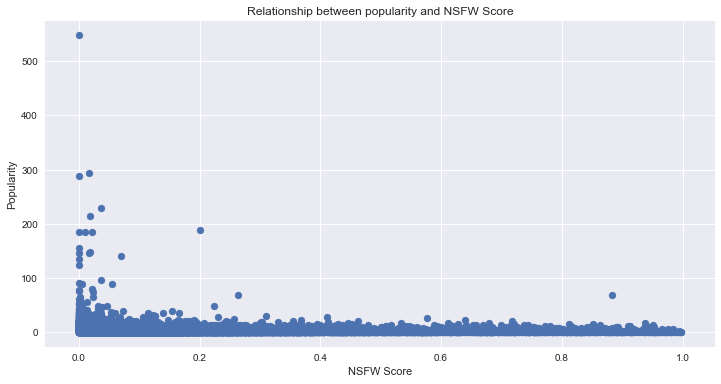

In [11]:
plt.scatter(movie_data['nsfw_score'], movie_data['popularity'])
plt.title('Relationship between popularity and NSFW Score')
plt.xlabel('NSFW Score')
plt.ylabel('Popularity')
plt.show()

In [102]:
movie_data.loc[:,'popularity'] = pd.to_numeric(movie_data['popularity'])

In [108]:
movie_data[(movie_data.popularity > 100) & (movie_data.nsfw_score < 0.4)]

,title,budget,id,original_language,popularity,revenue,vote_average,vote_count,nsfw_score
292,Pulp Fiction,8000000,680,en,140.950236,2.139288e+08,8.3,8670.0,0.069993
12481,The Dark Knight,185000000,155,en,123.167259,1.004558e+09,8.3,12269.0,0.000733
14551,Avatar,237000000,19995,en,185.070892,2.787965e+09,7.2,12114.0,0.011014
23675,Gone Girl,61000000,210577,en,154.801009,3.693304e+08,7.9,6023.0,0.000646
24351,John Wick,20000000,245891,en,183.870374,8.876166e+07,7.0,5499.0,0.000193
24455,Big Hero 6,165000000,177572,en,213.849907,6.521054e+08,7.8,6289.0,0.019436
24873,The Hunger Games: Mockingjay - Part 1,125000000,131631,en,147.098006,7.521002e+08,6.6,5767.0,0.018422
26560,Pirates of the Caribbean: Dead Men Tell No Tales,230000000,166426,en,133.827820,7.941920e+08,6.6,2814.0,0.000010
26564,Deadpool,58000000,293660,en,187.860492,7.831130e+08,7.4,11444.0,0.200710
26566,Guardians of the Galaxy Vol. 2,200000000,283995,en,185.330992,8.634161e+08,7.6,4858.0,0.022276


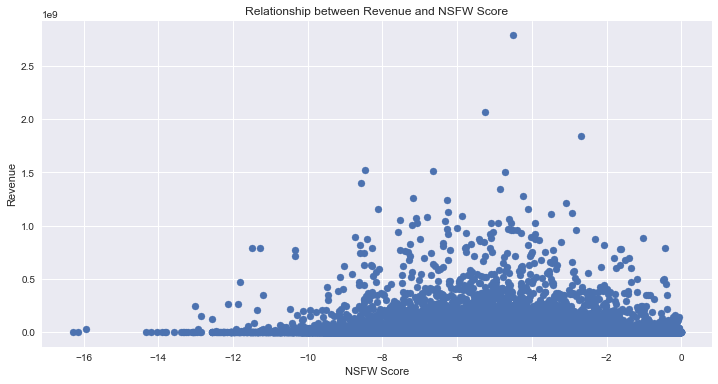

In [157]:
#Drop revenue 0s
plt.scatter(np.log(movie_data['nsfw_score']), movie_data['revenue'])
plt.title('Relationship between Revenue and NSFW Score')
plt.xlabel('NSFW Score')
plt.ylabel('Revenue')
plt.show()

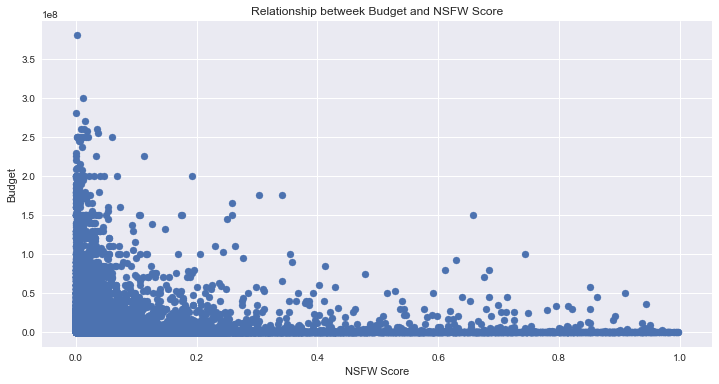

In [124]:
#Drop the budget 0s
plt.scatter(df['nsfw_score'], df['budget'])
plt.title('Relationship betweek Budget and NSFW Score')
plt.xlabel('NSFW Score')
plt.ylabel('Budget')
plt.show()

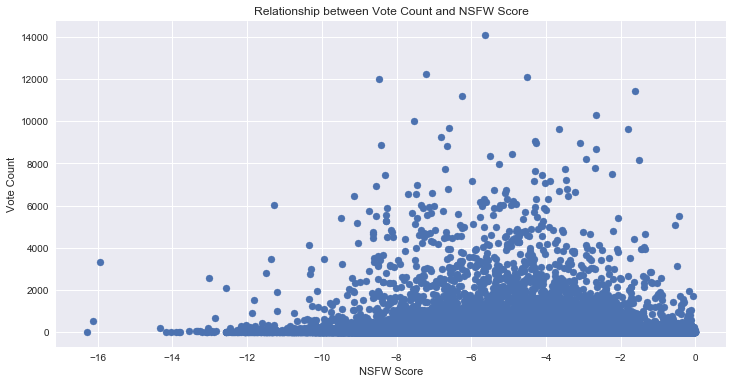

In [158]:
plt.scatter(np.log(movie_data['nsfw_score']), movie_data['vote_count'])
plt.title('Relationship between Vote Count and NSFW Score')
plt.xlabel('NSFW Score')
plt.ylabel('Vote Count')
plt.show()

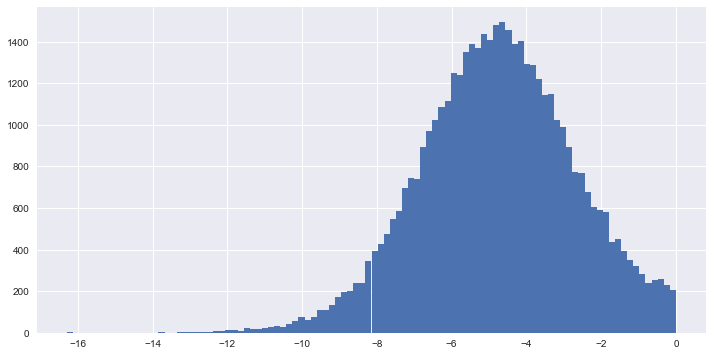

In [151]:
plt.hist(np.log(movie_data['nsfw_score']), bins=100)
plt.show()

^how do we account for this?

In [147]:
data = np.log(movie_data['nsfw_score'])

In [2]:
movie_data[movie_data.original_language == 'en'].sum()

NameError: name 'movie_data' is not defined